This notebook calculates NK-NK covariance of a same bin: 0.4<z<0.6

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import pyccl as ccl
import sys
sys.path.insert(0, '/global/u1/z/zhzhuoqi/tjpcov/TJPCov')
sys.path.insert(0, '/global/u1/z/zhzhuoqi/firecrown/firecrown/')
sys.path.insert(0, '/global/homes/z/zhzhuoqi/.conda/envs/my-conda-env/lib/python3.8/site-packages/')
sys.path.insert(0, '/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1-v2/envs/desc/lib/python3.7/site-packages/')
import pymaster as nmt
from tjpcov import wigner_transform, bin_cov, parse

In [2]:
# HEALPix map resolution
nside = 512

# a) Read and apodize mask
m = hp.read_map('mask.fits')
m = hp.pixelfunc.ud_grade(m, nside)
mask = nmt.mask_apodization(m,
                            1., apotype="Smooth")

/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1-v2/envs/desc/lib/python3.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [3]:
#generate ell according to map resolution
ell = np.linspace(2, int(nside*3), int(nside*3-1))
ell_bins = np.linspace(2, int(nside*3), int(nside*3./20))

In [4]:
#ccl correlations
def correlation(z, z_h): 
    
    ell = np.linspace(2, int(nside*4), int(nside*4-1))
    
    #generate bias
    bz=1.20*np.ones_like(z_h)

    # Initialize tracers  
    cosmo_cls=ccl.Cosmology(Omega_c=0.21, Omega_b=0.045, Omega_g=0, Omega_k=0,
                              h=0.71, sigma8=0.80, n_s=0.964, Neff=0, m_nu=0.0,
                              w0=-1, wa=0, T_CMB=2.7, transfer_function='bbks',
                              mass_function='tinker')  

    #generate tracers 
    trcrs = {}
    trcrs['nc']=ccl.NumberCountsTracer(cosmo_cls,has_rsd=False,dndz=(z,z_h),bias=(z,bz))
    trcrs['cmbl']=ccl.CMBLensingTracer(cosmo_cls,1100.)

    #CCL Power spectra
    cl_ccl = {}
    cl_ccl['nk']=ccl.angular_cl(cosmo_cls,trcrs['nc'],trcrs['cmbl'],ell)
    cl_ccl['nn']=ccl.angular_cl(cosmo_cls,trcrs['nc'],trcrs['nc'],ell)
    cl_ccl['kk']=ccl.angular_cl(cosmo_cls,trcrs['cmbl'],trcrs['cmbl'],ell)

    return cl_ccl


In [5]:
#load z and nz
z = np.loadtxt('z.txt')
zn = np.loadtxt('zn.txt')

In [6]:
#load and generate tracer noise

cmb_noise_smth = np.loadtxt('full_noise.txt')[2:nside*4+1]
#cmb_noise_smth = np.interp(ell_bins[:-1], ell, cmb_noise)

d2r=np.pi/180
Ngal = 1.03 #arc_min^2
sigma_e=.0097
b = 1.0*np.ones(len(z)) #Galaxy bias (constant with scale and z)
AI = .5*np.ones(len(z)) #Galaxy bias (constant with scale and z)
Ngal=Ngal*3600/d2r**2

NN_noise = 1./Ngal

In [7]:
#get correlations
cl_ccl = correlation(z, zn)
cl_nn_tt = cl_ccl['nn'] + NN_noise
cl_nk_te = cl_ccl['nk']
cl_nk_tb = 0*cl_ccl['nk']
cl_kk_ee = cl_ccl['kk'] + cmb_noise_smth
cl_kk_eb = 0*cl_ccl['kk']
cl_kk_bb = 0*cl_ccl['kk']

##### This is where I'm not sure

In [8]:
def get_sample_field():
    mp_t, mp_q, mp_u = hp.synfast([cl_nn_tt, cl_kk_ee, cl_kk_bb, cl_nk_te],
                                  nside, verbose=False)
    return nmt.NmtField(mask, [mp_t]), nmt.NmtField(mask, [mp_q, mp_u])


# We also copy this function from sample_workspaces.py. It computes
# power spectra given a pair of fields and a workspace.
def compute_master(f_a, f_b, wsp):
    cl_coupled = nmt.compute_coupled_cell(f_a, f_b)
    cl_decoupled = wsp.decouple_cell(cl_coupled)

    return cl_decoupled

In [9]:
print("Field")
f0, f2 = get_sample_field()


Field


In [10]:
# generate bandpowers and weights based on ell 

bpws = np.digitize(ell, ell_bins)-1
bpws[-1] = -1


weights = []
for i in range(0, max(bpws)+2):
    count = np.count_nonzero(bpws == i)
    for j in range (0, count):
        weights.append(1./count)
weights.append(1)
weights = np.array(weights)

##### I basically follows namaster steps in the following cells

In [11]:
b = nmt.NmtBin(nside=nside, ells=ell, bpws=bpws, weights=weights)
print("Workspace")
w00 = nmt.NmtWorkspace()
w00.compute_coupling_matrix(f0, f0, b)
w02 = nmt.NmtWorkspace()
w02.compute_coupling_matrix(f0, f2, b)
w22 = nmt.NmtWorkspace()
w22.compute_coupling_matrix(f2, f2, b)
cl_00 = compute_master(f0, f0, w00)
cl_02 = compute_master(f0, f2, w02)
cl_22 = compute_master(f2, f2, w22)
n_ell = len(cl_00[0])

Workspace


In [12]:
print("Covariance")
# First we generate a NmtCovarianceWorkspace object to precompute
# and store the necessary coupling coefficients
cw = nmt.NmtCovarianceWorkspace()
# This is the time-consuming operation
# Note that you only need to do this once,
# regardless of spin
cw.compute_coupling_coefficients(f0, f0, f0, f0)

Covariance


In [13]:
covar_02_02 = nmt.gaussian_covariance(cw, 0, 2, 0, 2,  # Spins of the 4 fields
                                      [cl_nn_tt],  # TT    cla1b1
                                      [cl_nk_te, cl_nk_tb],  # TE, TB cla1b2   
                                      [cl_nk_te, cl_nk_tb],  # ET, BT cla2b1
                                      [cl_kk_ee, cl_kk_eb,
                                       cl_kk_eb, cl_kk_bb],  # EE, EB, BE, BB cla2b2    
                                                       # "2" is a spin-2 field and has two components
                                      w02, wb=w02).reshape([n_ell, 2,
                                                            n_ell, 2])


covar_TE_TE = covar_02_02[:, 0, :, 0]
print(np.shape(covar_02_02))

(75, 2, 75, 2)


In [14]:
# Wigner transform, from TJPcov
tracer_comb1 = ['gc0','ck']
tracer_comb2 = ['gc0','ck']

WT_factors={}
WT_factors['ck','wl']=(0,2)
WT_factors['wl','ck']=(2,0)
WT_factors['gc','ck']=(0,0)
WT_factors['ck','gc']=(0,0)


def get_cov_WT_spin(tracer_comb=None):
#     tracers=tuple(i.split('_')[0] for i in tracer_comb)
    tracers=[]
    for i in tracer_comb:
        if 'ck' in i:
            tracers+=['ck']
        if 'wl' in i:
            tracers+=['wl']
        if 'gc' in i:
            tracers += ['gc'] 
    return WT_factors[tuple(tracers)]



th_min=1/60 # in degrees
th_max=300./60
n_th_bins=20
th_bins=np.logspace(np.log10(2.5/60.),np.log10(250./60.),n_th_bins+1)
th=np.logspace(np.log10(th_min),np.log10(th_max),3000) #covariance is oversampled at th values and then binned.
th2=np.linspace(1,th_max*1.02,3000) #binned covariance can be sensitive to the th values. Make sue you check convergence for your application
th=np.unique(np.sort(np.append(th,th2)))
thb=0.5*(th_bins[1:]+th_bins[:-1])
ell_wtf = ell_bins[:-1]
# Wigner Transform setup... 
WT_kwargs={'l': ell_wtf,
           'theta': th*d2r,'s1_s2':[(0,2),(2,0),(0,0)]}
WT=wigner_transform(**WT_kwargs)

fsky = 445./(4*np.pi*((180.**2)/(np.pi**2)))
norm=np.pi*4*fsky
covar_TE_TE = covar_TE_TE/norm

s1_s2_1=get_cov_WT_spin(tracer_comb=tracer_comb1)
s1_s2_2=get_cov_WT_spin(tracer_comb=tracer_comb2)
if isinstance(s1_s2_1,dict):
    s1_s2_1=s1_s2_1[xi_plus_minus1] 
if isinstance(s1_s2_2,dict):
    s1_s2_2=s1_s2_2[xi_plus_minus2] 
th,cov_=WT.projected_covariance2(l_cl=ell_wtf,s1_s2=s1_s2_1, s1_s2_cross=s1_s2_2,
                                              cl_cov=covar_TE_TE)


thb,cov=bin_cov(r=th/d2r,r_bins=th_bins,cov=cov_) 


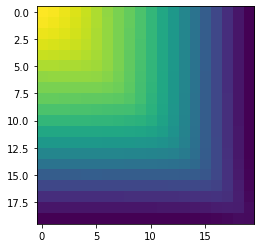

In [15]:
plt.imshow(cov)